PHASE 3 - PART 2: TRANSFER LEARNING ON HORSE-CAT-DOG DATASET
Loading Horse-Cat-Dog dataset...
Loading class horse (202 images)
Loading class cat (202 images)
Loading class dog (202 images)
Loaded 606 images from 3 classes
Train set: 423 samples
Validation set: 61 samples
Test set: 122 samples

Dataset Statistics:
Number of classes: 3
Train samples: 423
Validation samples: 61
Test samples: 122

EXPERIMENT 1: FROZEN BASE MODEL
Creating transfer learning model with frozen base layers...
Model created with 390179 total parameters
Trainable parameters: 34307
Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 1.8706 - accuracy: 0.4757
Epoch 1: val_accuracy improved from -inf to 0.63934, saving model to hcd_frozen_model.keras
14/14 [==============================] - 2s 66ms/step - loss: 1.8455 - accuracy: 0.4799 - val_loss: 1.0795 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.4257 - accuracy: 0.6194
Epoch 2: val_ac

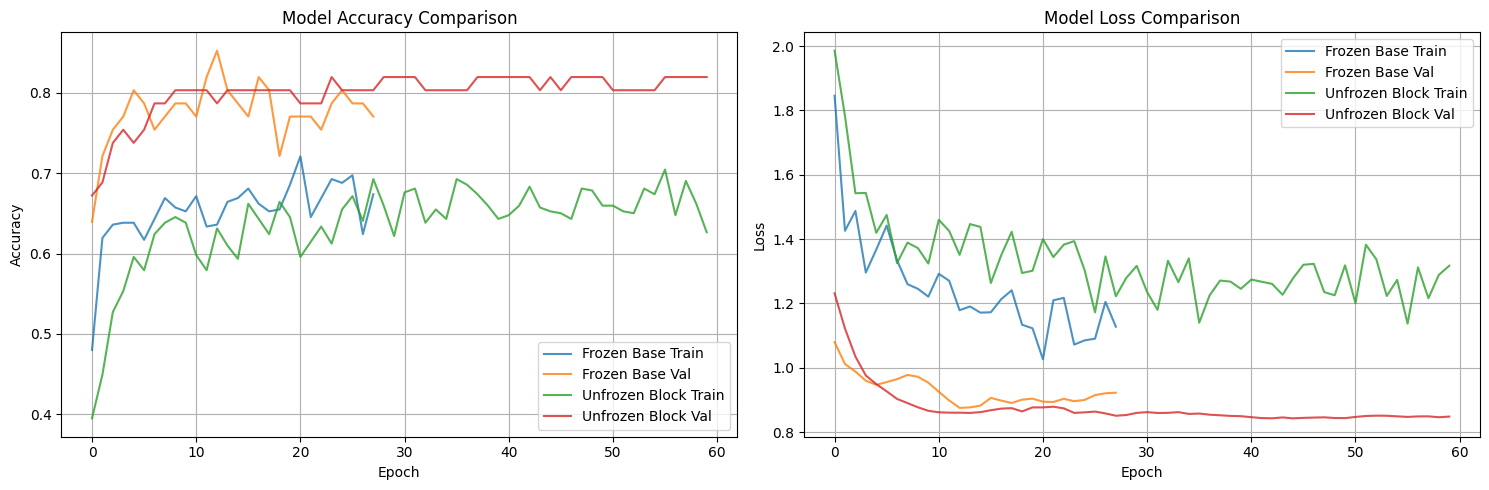


Best model: Frozen Base Model
Best test accuracy: 0.7295

DETAILED ANALYSIS OF BEST MODEL


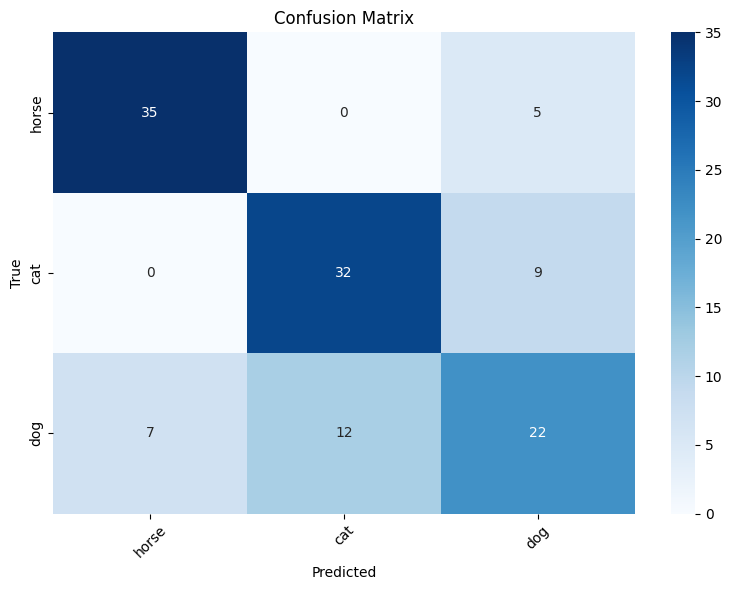

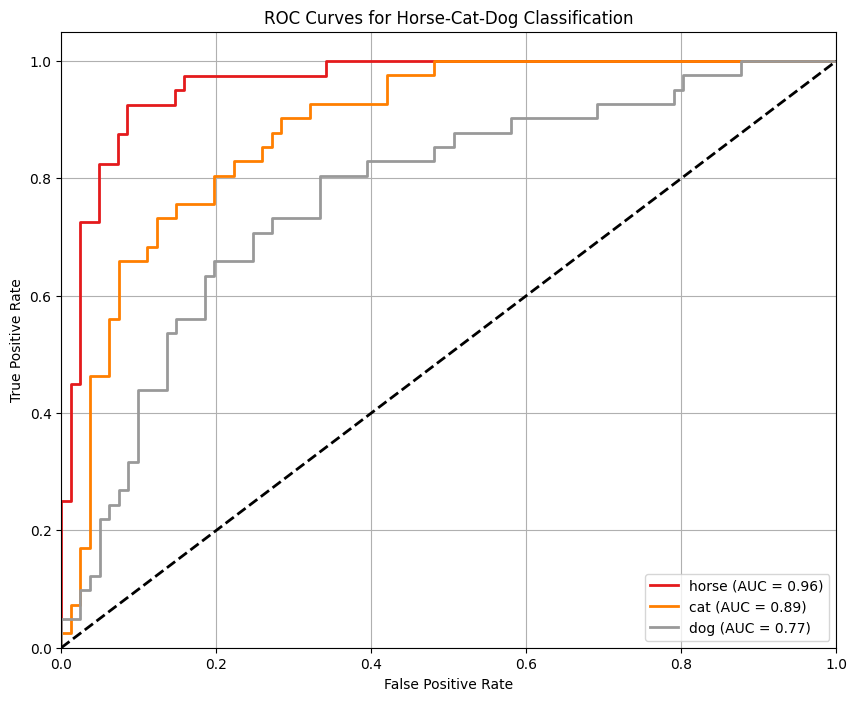

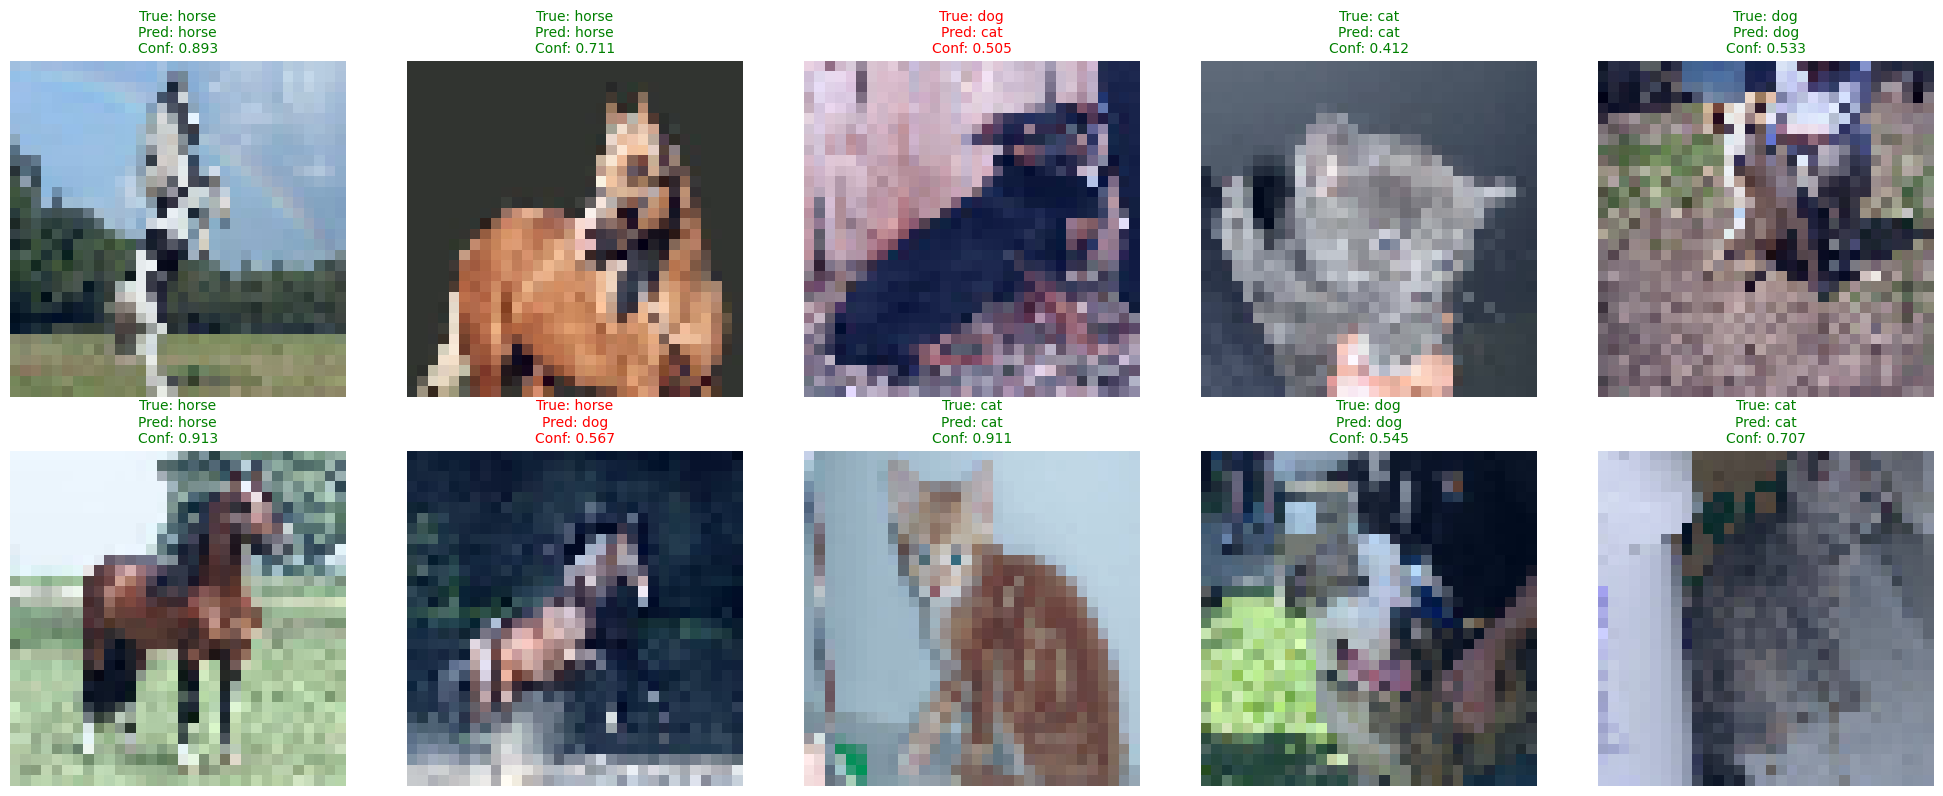


Classification Report:
              precision    recall  f1-score   support

       horse     0.8333    0.8750    0.8537        40
         cat     0.7273    0.7805    0.7529        41
         dog     0.6111    0.5366    0.5714        41

    accuracy                         0.7295       122
   macro avg     0.7239    0.7307    0.7260       122
weighted avg     0.7230    0.7295    0.7250       122


PHASE 3 PART 2 COMPLETED SUCCESSFULLY!
Best model saved as: hcd_frozen_model.keras


In [4]:
# PHASE 3 - PART 2: Transfer Learning on Horse-Cat-Dog Dataset (FIXED)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K  # For clearing session
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image

class HorseCatDogTransferLearning:
    def __init__(self, base_model_path='phase2_best_model.keras'):
        """Initialize with pre-trained model from Phase 2"""
        self.base_model_path = base_model_path
        self.class_names = ['horse', 'cat', 'dog']
        self.num_classes = 3
        self.input_shape = (32, 32, 3)
        
    def load_hcd_data(self, data_dir):
        """Load and preprocess Horse-Cat-Dog dataset"""
        print("Loading Horse-Cat-Dog dataset...")
        
        images = []
        labels = []
        
        for class_idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(data_dir, class_name)
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            print(f"Loading class {class_name} ({len(image_files)} images)")
            
            for img_file in image_files:
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = load_img(img_path, target_size=(32, 32))
                    img_array = img_to_array(img) / 255.0
                    
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue
        
        images = np.array(images)
        labels = np.array(labels)
        
        print(f"Loaded {len(images)} images from {len(self.class_names)} classes")
        return images, labels
    
    def preprocess_data(self, X, y):
        """Preprocess data similar to Phase 2"""
        X = X.astype('float32')
        
        # Calculate mean and std from current data
        mean = np.mean(X, axis=(0, 1, 2))
        std = np.std(X, axis=(0, 1, 2))
        
        # Standardize
        X = (X - mean) / (std + 1e-7)
        
        return X, y, mean, std
    
    def split_data(self, X, y):
        """Split data into train/val/test (70/10/20)"""
        # First split: 80% train+val, 20% test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Second split: 70% train, 10% val from the remaining 80%
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
        )
        
        # Convert to categorical
        y_train_cat = to_categorical(y_train, self.num_classes)
        y_val_cat = to_categorical(y_val, self.num_classes)
        y_test_cat = to_categorical(y_test, self.num_classes)
        
        print(f"Train set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        return X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat, y_test
    
    def count_trainable_params(self, model):
        """Helper function to count trainable parameters"""
        trainable_count = int(np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]))
        return trainable_count
    
    def create_transfer_model_frozen(self):
        """Create transfer learning model with frozen base layers"""
        print("Creating transfer learning model with frozen base layers...")
        K.clear_session()  # Clear previous session
        
        # Load pre-trained model
        base_model = load_model(self.base_model_path)
        
        # Remove the last classification layer
        base_features = base_model.layers[-2].output
        
        # Add new classification head with unique names
        x = Dense(256, activation='relu', 
                 kernel_regularizer=l2(0.001),
                 name='hcd_dense1')(base_features)
        x = BatchNormalization(name='hcd_bn1')(x)
        x = Dropout(0.5, name='hcd_dropout1')(x)
        
        predictions = Dense(self.num_classes, 
                           activation='softmax',
                           name='hcd_output')(x)
        
        # Create new model
        transfer_model = Model(inputs=base_model.input, outputs=predictions)
        
        # Freeze all layers except the new ones
        for layer in transfer_model.layers[:-4]:  # Adjust index based on new layers
            layer.trainable = False
        
        print(f"Model created with {transfer_model.count_params()} total parameters")
        trainable_params = self.count_trainable_params(transfer_model)
        print(f"Trainable parameters: {trainable_params}")
        
        return transfer_model
    
    def create_transfer_model_unfrozen(self, num_blocks_to_unfreeze=1):
        """Create transfer learning model with some blocks unfrozen"""
        print(f"Creating transfer learning model with {num_blocks_to_unfreeze} block(s) unfrozen...")
        K.clear_session()  # Clear previous session
        
        # Load the frozen model as base
        base_model = load_model(self.base_model_path)
        
        # Remove the last classification layer
        base_features = base_model.layers[-2].output
        
        # Add new classification head with unique names
        x = Dense(256, activation='relu', 
                 kernel_regularizer=l2(0.001),
                 name='hcd_dense2')(base_features)
        x = BatchNormalization(name='hcd_bn2')(x)
        x = Dropout(0.5, name='hcd_dropout2')(x)
        
        predictions = Dense(self.num_classes, 
                           activation='softmax',
                           name='hcd_output2')(x)
        
        transfer_model = Model(inputs=base_model.input, outputs=predictions)
        
        # Identify conv blocks
        conv_blocks = []
        current_block = []
        
        # Find blocks using MaxPooling layers as separators
        for layer in transfer_model.layers[:-4]:
            current_block.append(layer)
            if 'max_pooling' in layer.name.lower():
                conv_blocks.append(current_block)
                current_block = []
        
        if current_block:
            conv_blocks.append(current_block)
        
        # Freeze all blocks
        for layer in transfer_model.layers[:-4]:
            layer.trainable = False
        
        # Unfreeze the last num_blocks_to_unfreeze blocks
        blocks_to_unfreeze = min(num_blocks_to_unfreeze, len(conv_blocks))
        for i in range(blocks_to_unfreeze):
            block_idx = len(conv_blocks) - 1 - i
            for layer in conv_blocks[block_idx]:
                layer.trainable = True
        
        trainable_params = self.count_trainable_params(transfer_model)
        total_params = transfer_model.count_params()
        print(f"Total parameters: {total_params}")
        print(f"Trainable parameters: {trainable_params} ({100*trainable_params/total_params:.1f}%)")
        
        return transfer_model
    
    # Rest of the class remains unchanged (create_data_generators, train_model, etc.)
    def create_data_generators(self):
        """Create data generators with augmentation"""
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.15,
            shear_range=0.15,
            brightness_range=[0.8, 1.2],
            channel_shift_range=0.1,
            fill_mode='nearest'
        )
        
        val_datagen = ImageDataGenerator()
        
        return train_datagen, val_datagen
    
    def train_model(self, model, X_train, y_train, X_val, y_val, 
                   model_name, optimizer='adam', learning_rate=0.0001, batch_size=32):
        """Train the transfer learning model"""
        
        # Compile model
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
        else:
            opt = RMSprop(learning_rate=learning_rate)
        
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Create data generators
        train_datagen, val_datagen = self.create_data_generators()
        train_datagen.fit(X_train)
        
        # Callbacks
        early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=15, 
            restore_best_weights=True, 
            verbose=1
        )
        
        model_checkpoint = ModelCheckpoint(
            model_name,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        )
        
        # Train model
        history = model.fit(
            train_datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=val_datagen.flow(X_val, y_val, batch_size=batch_size),
            epochs=100,
            callbacks=[early_stop, model_checkpoint, reduce_lr],
            verbose=1
        )
        
        return history
    
    def evaluate_model(self, model_path, X_test, y_test_cat, y_test):
        """Evaluate the trained model"""
        model = load_model(model_path)
        
        # Get predictions
        y_pred_proba = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred_proba, axis=1)
        
        # Calculate metrics
        test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
        
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision = precision_score(y_test, y_pred_labels, average='weighted')
        recall = recall_score(y_test, y_pred_labels, average='weighted')
        f1 = f1_score(y_test, y_pred_labels, average='weighted')
        
        print(f"\nModel Evaluation Results:")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        return {
            'test_acc': test_acc,
            'test_loss': test_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_pred_proba': y_pred_proba,
            'y_pred_labels': y_pred_labels
        }
    
    def plot_roc_curves(self, y_test, y_pred_proba):
        """Plot ROC curves for multiclass classification"""
        # Binarize the output
        y_test_bin = label_binarize(y_test, classes=range(self.num_classes))
        
        plt.figure(figsize=(10, 8))
        colors = plt.cm.Set1(np.linspace(0, 1, self.num_classes))
        
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[i], lw=2,
                    label=f'{self.class_names[i]} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Horse-Cat-Dog Classification')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    
    def plot_training_history(self, histories, names):
        """Plot training histories"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        for history, name in zip(histories, names):
            ax1.plot(history.history['accuracy'], label=f'{name} Train', alpha=0.8)
            ax1.plot(history.history['val_accuracy'], label=f'{name} Val', alpha=0.8)
            
            ax2.plot(history.history['loss'], label=f'{name} Train', alpha=0.8)
            ax2.plot(history.history['val_loss'], label=f'{name} Val', alpha=0.8)
        
        ax1.set_title('Model Accuracy Comparison')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        ax2.set_title('Model Loss Comparison')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred, save_path=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return cm
    
    def visualize_predictions(self, X_test, y_test, y_pred_labels, y_pred_proba, num_samples=10):
        """Visualize predictions with confidence scores"""
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.ravel()
        
        # Select random samples
        indices = np.random.choice(len(X_test), num_samples, replace=False)
        
        for i, idx in enumerate(indices):
            # Denormalize image for display
            img = X_test[idx]
            img = (img - img.min()) / (img.max() - img.min())
            
            axes[i].imshow(img)
            
            true_label = self.class_names[y_test[idx]]
            pred_label = self.class_names[y_pred_labels[idx]]
            confidence = y_pred_proba[idx][y_pred_labels[idx]]
            
            color = 'green' if y_test[idx] == y_pred_labels[idx] else 'red'
            
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                            color=color, fontsize=10)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

def main_hcd():
    """Main execution function for Horse-Cat-Dog transfer learning"""
    print("="*60)
    print("PHASE 3 - PART 2: TRANSFER LEARNING ON HORSE-CAT-DOG DATASET")
    print("="*60)
    
    # Initialize transfer learning class
    transfer = HorseCatDogTransferLearning()
    
    # Load and preprocess data
    data_dir = "Classification_Horse,Cat,Dog"  # Update this path to your dataset directory
    
    # Check if data directory exists
    if not os.path.exists(data_dir):
        print(f"Error: Dataset directory '{data_dir}' not found!")
        print("Please create dataset directories: horse/, cat/, dog/")
        return
    
    # Load data
    X, y = transfer.load_hcd_data(data_dir)
    
    # Preprocess data
    X, y, mean, std = transfer.preprocess_data(X, y)
    
    # Split data
    X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat, y_test = transfer.split_data(X, y)
    
    print(f"\nDataset Statistics:")
    print(f"Number of classes: {transfer.num_classes}")
    print(f"Train samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    
    # Experiment 1: Frozen base model
    print(f"\n{'='*50}")
    print("EXPERIMENT 1: FROZEN BASE MODEL")
    print(f"{'='*50}")
    
    model_frozen = transfer.create_transfer_model_frozen()
    history_frozen = transfer.train_model(
        model_frozen, X_train, y_train_cat, X_val, y_val_cat,
        'hcd_frozen_model.keras',
        optimizer='adam', learning_rate=0.001, batch_size=32
    )
    
    results_frozen = transfer.evaluate_model(
        'hcd_frozen_model.keras', X_test, y_test_cat, y_test
    )
    
    # Experiment 2: Unfreeze one block
    print(f"\n{'='*50}")
    print("EXPERIMENT 2: UNFROZEN ONE BLOCK")
    print(f"{'='*50}")
    
    model_unfrozen = transfer.create_transfer_model_unfrozen(num_blocks_to_unfreeze=1)
    history_unfrozen = transfer.train_model(
        model_unfrozen, X_train, y_train_cat, X_val, y_val_cat,
        'hcd_unfrozen_model.keras',
        optimizer='adam', learning_rate=0.0001, batch_size=32
    )
    
    results_unfrozen = transfer.evaluate_model(
        'hcd_unfrozen_model.keras', X_test, y_test_cat, y_test
    )
    
    # Compare results
    print(f"\n{'='*60}")
    print("RESULTS COMPARISON")
    print(f"{'='*60}")
    
    print("Frozen Model Results:")
    print(f"  Test Accuracy: {results_frozen['test_acc']:.4f}")
    print(f"  Precision: {results_frozen['precision']:.4f}")
    print(f"  Recall: {results_frozen['recall']:.4f}")
    print(f"  F1-Score: {results_frozen['f1_score']:.4f}")
    
    print("\nUnfrozen Model Results:")
    print(f"  Test Accuracy: {results_unfrozen['test_acc']:.4f}")
    print(f"  Precision: {results_unfrozen['precision']:.4f}")
    print(f"  Recall: {results_unfrozen['recall']:.4f}")
    print(f"  F1-Score: {results_unfrozen['f1_score']:.4f}")
    
    # Plot training histories
    transfer.plot_training_history(
        [history_frozen, history_unfrozen],
        ['Frozen Base', 'Unfrozen Block']
    )
    
    # Choose best model for detailed analysis
    if results_frozen['test_acc'] > results_unfrozen['test_acc']:
        best_model_name = 'hcd_frozen_model.keras'
        best_results = results_frozen
        print("\nBest model: Frozen Base Model")
    else:
        best_model_name = 'hcd_unfrozen_model.keras'
        best_results = results_unfrozen
        print("\nBest model: Unfrozen Block Model")
    
    print(f"Best test accuracy: {best_results['test_acc']:.4f}")
    
    # Detailed analysis of best model
    print(f"\n{'='*50}")
    print("DETAILED ANALYSIS OF BEST MODEL")
    print(f"{'='*50}")
    
    # Plot confusion matrix
    transfer.plot_confusion_matrix(
        y_test, best_results['y_pred_labels'],
        save_path='hcd_confusion_matrix.png'
    )
    
    # Plot ROC curves
    transfer.plot_roc_curves(
        y_test, best_results['y_pred_proba']
    )
    
    # Visualize predictions
    transfer.visualize_predictions(
        X_test, y_test, best_results['y_pred_labels'], 
        best_results['y_pred_proba']
    )
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, best_results['y_pred_labels'], 
                               target_names=transfer.class_names, digits=4))
    
    print(f"\n{'='*60}")
    print("PHASE 3 PART 2 COMPLETED SUCCESSFULLY!")
    print(f"{'='*60}")
    print(f"Best model saved as: {best_model_name}")

if __name__ == "__main__":
    main_hcd()